# SANTANDER CUSTOMER SATISFACTION

## Importing packages and reading files

In [4]:
import pandas as pd
import numpy as np
import qgrid
import warnings
warnings.filterwarnings("ignore")

In [5]:
train = pd.read_csv('data/train.csv')

## Analyzing and pre-processing

In [6]:
train_desc = train.describe()

In [7]:
## qgrid to see the dataframe in a better shape
qgrid.show_grid(train_desc,show_toolbar=True,grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

Analyzing the data I notice that there are some columns where all the values are zero, so I will drop this columns.

I've also noticed that there are some columns where the min/max values are -999999 or 99999 respectively, but as I don't know what each column represents I'm leaving it.

In [8]:
# checking wich columns contains only zero values:
only_zeros = (train == 0).all()

drop_zeros = only_zeros[only_zeros].index

# droping columns where all values are zero:

train = train.drop(drop_zeros,axis=1)

In [9]:
train.shape

(76020, 337)

### Separating inputs and output

In [10]:
X_train = train.drop(['TARGET','ID'],axis=1)
Y_train = train['TARGET']

### Analyzing the output imbalance

In [11]:
train['TARGET'].value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

<AxesSubplot:>

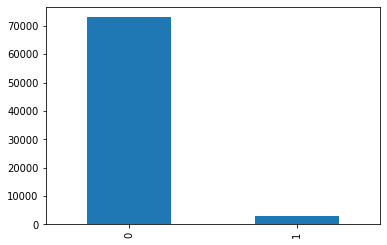

In [12]:
train['TARGET'].value_counts().plot(kind='bar')

there are clearly an imbalance, so I will use SMOTE technique to resample the data

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=0)

X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)


<AxesSubplot:xlabel='TARGET'>

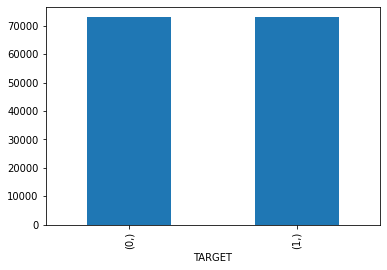

In [14]:
pd.DataFrame(Y_train_resampled).value_counts().plot(kind='bar')

### Normalizing and Applying PCA

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [16]:
# Normalizing the X resampled
scaler = MinMaxScaler(feature_range = (0, 1))
rescaledX = scaler.fit_transform(X_train_resampled)

# Selecting Attributes with PCA
pca = PCA(n_components =10)
X_transformed = pca.fit_transform(rescaledX)


## Selecting the best classifier model

Linear Regression, LinearDiscriminantAnalysis and GaussianNB were not considered in this evaluation, because they assume
the data is in a gaussian distribution.

KNN: 0.887608 (0.002938)
CART: 0.884574 (0.003021)
RANDOM FOREST: 0.900174 (0.002393)
ADB: 0.805683 (0.005132)
GRADIENT: 0.837842 (0.002580)
XGB: 0.874952 (0.002647)


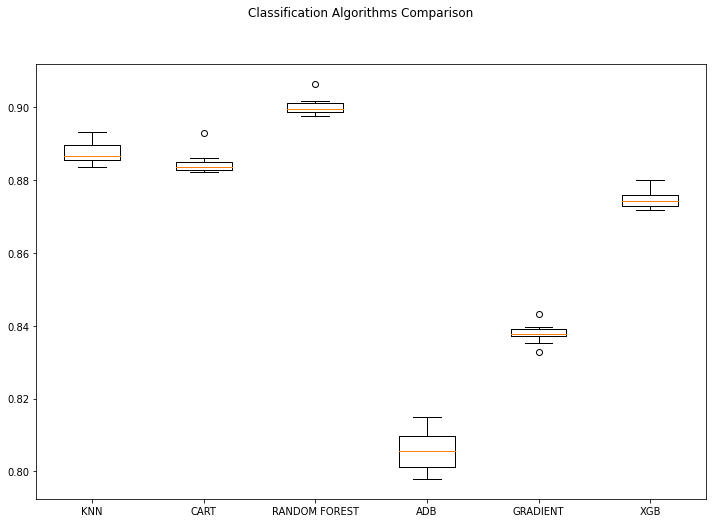

In [22]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Defining folds for the cross validation
num_folds = 10
seed=7

# Preparing models
modelos = []
modelos.append(('KNN', KNeighborsClassifier()))
modelos.append(('CART', DecisionTreeClassifier()))
modelos.append(('RANDOM FOREST', RandomForestClassifier(n_estimators = 100, max_features = 3)))
modelos.append(('ADB',AdaBoostClassifier(n_estimators = 30, random_state = seed)))
modelos.append(('GRADIENT', GradientBoostingClassifier(n_estimators = 100, random_state = seed)))
modelos.append(('XGB', XGBClassifier(verbosity=0)))

# Evaluating each model
resultados = []
nomes = []

for nome, modelo in modelos:
    kfold = KFold(n_splits = num_folds,shuffle=True, random_state = seed)
    cv_results = cross_val_score(modelo, X_transformed, Y_train_resampled, cv = kfold, scoring = 'accuracy')
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %f (%f)" % (nome, cv_results.mean(), cv_results.std())
    print(msg)

# Comparison Boxplot
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Classification Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

The best model through this evaluation was RANDOM FOREST

## Creating selected model and saving

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


teste_size = 0.33


seed = 7

# spliting data to evaluate
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X_transformed, Y_train_resampled,
                                                        test_size = teste_size, random_state = seed)

# creating model
modelo = RandomForestClassifier(n_estimators = 100, max_features = 3)

# Training
modelo.fit(X_treino, Y_treino)

# Score 
result = modelo.score(X_teste, Y_teste)
print("Accuracy: %.3f%%" % (result * 100.0))

Accuracy: 89.638%


In [64]:
# confusion matrix
from sklearn.metrics import confusion_matrix
previsoes = modelo.predict(X_teste)
matrix = confusion_matrix(Y_teste, previsoes)


print(matrix)

[[21352  2672]
 [ 2321 21843]]


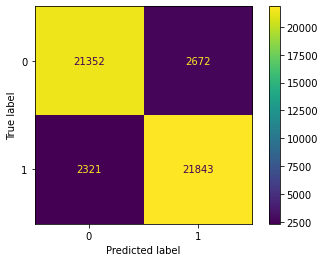

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(matrix).plot()

In [51]:
import pickle

# Saving
arquivo = 'RandomForest-Santander.sav'
pickle.dump(modelo, open(arquivo, 'wb'))


## Training test data

In [52]:
test = pd.read_csv('data/test.csv')

In [53]:
X_test = test.drop(['ID'],axis=1)

In [54]:
X_test = X_test.drop(drop_zeros,axis=1)

In [55]:
X_test_norm = scaler.transform(X_test)

In [56]:
X_test_transf = pca.transform(X_test_norm)

In [57]:
modelo_classificador_final = pickle.load(open('RandomForest-Santander.sav', 'rb'))

previsoes_teste = modelo_classificador_final.predict(X_test_transf)

In [58]:
test_id = pd.DataFrame(test['ID'])
df_prev_test = pd.DataFrame(previsoes_teste)

In [59]:
subm = pd.concat([test_id,df_prev_test],axis=1)

In [60]:
subm.columns = ['ID','TARGET']

In [61]:
subm.to_csv("submission-santander-kaggle.csv", index=False)

After uploading on Kaggle I received a score of 0.66703, and the leader got 0.82907, so there is definetly
improvement to be made.